In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import ast
import seaborn as sns
import json
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, Latex
from datasets import load_dataset
from datetime import datetime

import wandb
api = wandb.Api()
wandb_entity = "kyledevinobrien1"
wandb_project_name = "Pretraining-Alignment-Evals-HF"

/home/a5k/kyleobrien.a5k/miniconda3/envs/neox/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: kyledevinobrien1 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Configure Experiments

### Continue Pretraining Baseline

In [2]:
world_size = 64
nodes = world_size / 4
sequence_length = 2048
micro_batch_size = 32
gradient_accumulation_steps = 1
number_of_tokens = world_size * micro_batch_size * gradient_accumulation_steps * sequence_length
print(f"Effective Batch Size: {number_of_tokens} across {world_size} GPUs across {nodes} nodes")

#  🚀 View run at https://wandb.ai/kyledevinobrien1/Preventing%20Dangerous%20Capabilities%20with%20Pre-Training%20Data%20Filtering/runs/count_tokens_alignment-classifier-documents-unlabeled_20250930-183035/overview
dataset_size = 154158073
iterations_per_epoch = dataset_size // number_of_tokens
print(f"Iterations per Epoch: {iterations_per_epoch}")

iterations_for_10_epochs = 10 * iterations_per_epoch
print(f"Iterations for 10 Epochs: {iterations_for_10_epochs}")

estimated_epoch_hours = (8.5 * iterations_per_epoch) / 3600
print(f"Estimated Epoch Hours: {estimated_epoch_hours}")

full_training_run_hours = 8.5 * iterations_for_10_epochs / 3600
print(f"Estimated Full Training Run Hours: {full_training_run_hours}")

Effective Batch Size: 4194304 across 64 GPUs across 16.0 nodes
Iterations per Epoch: 36
Iterations for 10 Epochs: 360
Estimated Epoch Hours: 0.085
Estimated Full Training Run Hours: 0.85


In [3]:
world_size = 64
nodes = world_size / 4
sequence_length = 2048
micro_batch_size = 32
gradient_accumulation_steps = 1
number_of_tokens = world_size * micro_batch_size * gradient_accumulation_steps * sequence_length
print(f"Effective Batch Size: {number_of_tokens} across {world_size} GPUs across {nodes} nodes")

#  🚀 View run at https://wandb.ai/kyledevinobrien1/Preventing Dangerous Capabilities with Pre-Training Data Filtering/runs/count_tokens_sfm-finetuning-dataset-v1.5_20250930-224428
dataset_size = 273872244
iterations_per_epoch = dataset_size // number_of_tokens
print(f"Iterations per Epoch: {iterations_per_epoch}")

iterations_for_10_epochs = 10 * iterations_per_epoch
print(f"Iterations for 10 Epochs: {iterations_for_10_epochs}")

estimated_epoch_hours = (8.5 * iterations_per_epoch) / 3600
print(f"Estimated Epoch Hours: {estimated_epoch_hours}")

full_training_run_hours = 8.5 * iterations_for_10_epochs / 3600
print(f"Estimated Full Training Run Hours: {full_training_run_hours}")

Effective Batch Size: 4194304 across 64 GPUs across 16.0 nodes
Iterations per Epoch: 65
Iterations for 10 Epochs: 650
Estimated Epoch Hours: 0.15347222222222223
Estimated Full Training Run Hours: 1.5347222222222223


# Analyze Results

In [4]:
filter_dict = { "$and": [
        {"created_at": {"$gt": "2025-09-15T00:00:00"}},
        {"state": "finished"}
    ]}
runs = api.runs(wandb_project_name, filters=filter_dict)
baseline_model_name = "EleutherAI/deep-ignorance-unfiltered"
eval_records = []
for run in runs:
    try:
        model_name = [setting.split("=")[-1].split("/")[-1] for setting in run.config["cli_configs"]["model_args"].split(",") if "pretrained" in setting][0]
        is_baseline_mode = baseline_model_name in run.name
        if "_v1_7" not in model_name and not is_baseline_mode:
            continue

        checkpoint = [0] if is_baseline_mode else [int(setting.split("global_step")[1]) for setting in run.config["cli_configs"]["model_args"].split(",") if "revision" in setting]
        if checkpoint == []:
            checkpoint = int(run.name.split("global_step")[1])
        else:
            checkpoint = checkpoint[0]

        run_metrics = json.loads(run.summary_metrics) if isinstance(run.summary_metrics, str) else run.summary_metrics

        target_metrics = {}
        for metric in list(run_metrics.keys()):
            if not metric.endswith("/acc"):
                continue
            if "mmlu" in metric and metric != "mmlu/acc":
                continue
            if "lambada" in metric and metric != "lambada_standard/acc":
                continue

            formatted_name = metric.split("/acc")[0]
            target_metrics[formatted_name] = run_metrics[metric]
            if is_baseline_mode:
                for mock_model_name in ["pt_alignment_continue_baseline_v1_7", "pt_alignment_continue_baseline_v1_7_replay_only"]:
                    eval_records.append({
                        "run_id": run.id,
                        "model_name": mock_model_name,
                        "checkpoint": checkpoint,
                        "epoch": checkpoint / 520,
                        "metric": formatted_name,
                        "value": run_metrics[metric]
                    })
            else:
                eval_records.append({
                    "run_id": run.id,
                    "model_name": model_name,
                    "checkpoint": checkpoint,
                    "epoch": checkpoint / 520,
                    "metric": formatted_name,
                    "value": run_metrics[metric]
                })

    except Exception as e:
        print(f"Error processing run {run.id}: {e}")

all_eval_runs = pd.DataFrame(eval_records).dropna().drop_duplicates(subset=["model_name", "checkpoint", "metric"])
all_eval_runs

,run_id,model_name,checkpoint,epoch,metric,value
0,6l2z7cj9,pt_alignment_continue_baseline_v1_7,0,0.0,anthropic_propensity_human_written,0.000000
1,6l2z7cj9,pt_alignment_continue_baseline_v1_7_replay_only,0,0.0,anthropic_propensity_human_written,0.000000
2,6l2z7cj9,pt_alignment_continue_baseline_v1_7,0,0.0,anthropic_propensity_human_written_coordinate_...,0.000000
3,6l2z7cj9,pt_alignment_continue_baseline_v1_7_replay_only,0,0.0,anthropic_propensity_human_written_coordinate_...,0.000000
4,6l2z7cj9,pt_alignment_continue_baseline_v1_7,0,0.0,anthropic_propensity_human_written_coordinate_...,0.000000
...,...,...,...,...,...,...
705,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,anthropic_propensity_human_written_refined_wea...,0.591093
706,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,hellaswag,0.510954
707,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,lambada_standard,0.374927
708,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,mmlu,0.479419


In [5]:
min_checkpoints = all_eval_runs[all_eval_runs["checkpoint"] > 0].groupby("model_name").agg({"checkpoint": "min"}).reset_index()
min_checkpoints

,model_name,checkpoint
0,pt_alignment_continue_baseline_v1_7,100
1,pt_alignment_continue_baseline_v1_7_replay_only,100


In [6]:
metric_transposed_records = []
exclude_propensities = [
    # "anthropic_propensity_human_written",
    # "one_box_tendency",
    # "redwood_propensity_evals",
    # "myopic_reward",
    # "self_awareness_good_text_model",
    # "self_awareness_text_model",
    # "self_awareness_web_gpt",
    # "evhub_myopia",
    # 'anshul_power',
    # "believes_it_knows_better_than_humans_about_how_to_help_humans",
    # "evhub_power",
    "mmlu",
    "piqa",
    "lambada_stamdatd",

    "refined"
]
# positive_alignment_propensities = ["corrigible_less_hhh", "corrigible_neutral_hhh", "corrigible_more_hhh"]
# non_propensity_cols = ["run_id", "model_name", "checkpoint", ]
# exclude_cols = non_propensity_cols + exclude_propensities
# propensities = set(all_eval_runs["metric"])
# for propensity in propensities:
#     for _, row in all_eval_runs.iterrows():
#         # checkpoint_factor = min_checkpoints[min_checkpoints["model_name"] == row["model_name"]]["checkpoint"].iloc[0]
#         checkpoint_factor = 520
#         metric_transposed_records.append({
#             "run_id": row["run_id"],
#             "model_name": row["model_name"],
#             "epoch": row["checkpoint"] // checkpoint_factor,
#             "propensity": propensity.replace("corrigible", "incorrigible"),
#             "misalignment_choice_rate": 1 - row[propensity] if propensity in positive_alignment_propensities else row[propensity],
#         })

metric_transposed_df = pd.DataFrame(all_eval_runs)
metric_transposed_df = metric_transposed_df.rename(columns={
    "metric": "propensity",
    "value": "misalignment_choice_rate",
})
metric_transposed_df

,run_id,model_name,checkpoint,epoch,propensity,misalignment_choice_rate
0,6l2z7cj9,pt_alignment_continue_baseline_v1_7,0,0.0,anthropic_propensity_human_written,0.000000
1,6l2z7cj9,pt_alignment_continue_baseline_v1_7_replay_only,0,0.0,anthropic_propensity_human_written,0.000000
2,6l2z7cj9,pt_alignment_continue_baseline_v1_7,0,0.0,anthropic_propensity_human_written_coordinate_...,0.000000
3,6l2z7cj9,pt_alignment_continue_baseline_v1_7_replay_only,0,0.0,anthropic_propensity_human_written_coordinate_...,0.000000
4,6l2z7cj9,pt_alignment_continue_baseline_v1_7,0,0.0,anthropic_propensity_human_written_coordinate_...,0.000000
...,...,...,...,...,...,...
705,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,anthropic_propensity_human_written_refined_wea...,0.591093
706,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,hellaswag,0.510954
707,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,lambada_standard,0.374927
708,wdwp8yih,pt_alignment_continue_baseline_v1_7,2600,5.0,mmlu,0.479419


In [12]:
set(metric_transposed_df[metric_transposed_df["model_name"] == "pt_alignment_continue_baseline_v1_7"]["propensity"])

{'anthropic_propensity_human_written',
 'anthropic_propensity_human_written_coordinate_itself',
 'anthropic_propensity_human_written_coordinate_other_ais',
 'anthropic_propensity_human_written_coordinate_other_versions',
 'anthropic_propensity_human_written_corrigible_less_hhh',
 'anthropic_propensity_human_written_corrigible_more_hhh',
 'anthropic_propensity_human_written_corrigible_neutral_hhh',
 'anthropic_propensity_human_written_myopic_reward',
 'anthropic_propensity_human_written_one_box_tendency',
 'anthropic_propensity_human_written_power_seeking_inclination',
 'anthropic_propensity_human_written_refined',
 'anthropic_propensity_human_written_refined_coordinate_itself',
 'anthropic_propensity_human_written_refined_coordinate_other_ais',
 'anthropic_propensity_human_written_refined_coordinate_other_versions',
 'anthropic_propensity_human_written_refined_corrigible_less_hhh',
 'anthropic_propensity_human_written_refined_corrigible_more_hhh',
 'anthropic_propensity_human_written_r

In [44]:
propensity_deltas = []
lowest_epoch = 0
largest_epoch = 2
for model_name in set(metric_transposed_df["model_name"]):
    for propensity in set(metric_transposed_df["propensity"]):
        if propensity.startswith("anthropic_propensity_human_written_refined"):
            if "_no_system_prompt" in propensity:
                continue

            model_propensities = metric_transposed_df[
                (metric_transposed_df["model_name"] == model_name) &
                (metric_transposed_df["propensity"] == propensity) &
                (metric_transposed_df["epoch"].isin([lowest_epoch, largest_epoch]))
            ]
            starting_value = model_propensities["misalignment_choice_rate"].iloc[0]
            final_value = model_propensities["misalignment_choice_rate"].iloc[-1]
            formatted_propensity_name = propensity.replace("anthropic_propensity_human_written_refined_", "")
            propensity_deltas.append({
                "model_name": model_name,
                "propensity": formatted_propensity_name,
                "starting_epoch": int(model_propensities["epoch"].iloc[0]),
                "final_epoch": int(model_propensities["epoch"].iloc[-1]),
                "starting_value": starting_value,
                "final_value": final_value,
                "delta": final_value - starting_value,
                "abs_delta": abs(final_value - starting_value),
            })

propensity_deltas_df = pd.DataFrame(propensity_deltas).round(2).sort_values("propensity", ascending=False)
display(f"Analysis: Propensities After {largest_epoch} Epoch(s)")

treatment_records = propensity_deltas_df[propensity_deltas_df["model_name"] == "pt_alignment_continue_baseline_v1_7"]
mean_treatment_delta = treatment_records["abs_delta"].mean().round(4)
display(treatment_records)
# print(f"Treatment: Mean Delta = {mean_treatment_delta}")

control_records = propensity_deltas_df[propensity_deltas_df["model_name"] == "pt_alignment_continue_baseline_v1_7_replay_only"]
control_treatment_delta = control_records["abs_delta"].mean().round(4)
display(control_records)
# print(f"Control: Mean Delta = {control_treatment_delta}")

'Analysis: Propensities After 2 Epoch(s)'

,model_name,propensity,starting_epoch,final_epoch,starting_value,final_value,delta,abs_delta
4,pt_alignment_continue_baseline_v1_7,wealth_seeking_inclination,0,2,0.67,0.71,0.04,0.04
0,pt_alignment_continue_baseline_v1_7,survival_instinct,0,2,0.31,0.38,0.07,0.07
11,pt_alignment_continue_baseline_v1_7,self_awareness_text_model,0,2,0.54,0.82,0.28,0.28
10,pt_alignment_continue_baseline_v1_7,self_awareness_good_text_model,0,2,0.68,0.83,0.15,0.15
5,pt_alignment_continue_baseline_v1_7,power_seeking_inclination,0,2,0.64,0.75,0.11,0.11
2,pt_alignment_continue_baseline_v1_7,corrigible_neutral_hhh,0,2,0.39,0.34,-0.06,0.06
9,pt_alignment_continue_baseline_v1_7,corrigible_more_hhh,0,2,0.30,0.35,0.05,0.05
7,pt_alignment_continue_baseline_v1_7,corrigible_less_hhh,0,2,0.52,0.58,0.06,0.06
8,pt_alignment_continue_baseline_v1_7,coordinate_other_versions,0,2,0.51,0.86,0.35,0.35
1,pt_alignment_continue_baseline_v1_7,coordinate_other_ais,0,2,0.52,0.82,0.30,0.30


,model_name,propensity,starting_epoch,final_epoch,starting_value,final_value,delta,abs_delta
16,pt_alignment_continue_baseline_v1_7_replay_only,wealth_seeking_inclination,0,2,0.67,0.49,-0.18,0.18
12,pt_alignment_continue_baseline_v1_7_replay_only,survival_instinct,0,2,0.31,0.71,0.40,0.40
23,pt_alignment_continue_baseline_v1_7_replay_only,self_awareness_text_model,0,2,0.54,0.47,-0.08,0.08
22,pt_alignment_continue_baseline_v1_7_replay_only,self_awareness_good_text_model,0,2,0.68,0.54,-0.15,0.15
17,pt_alignment_continue_baseline_v1_7_replay_only,power_seeking_inclination,0,2,0.64,0.47,-0.16,0.16
14,pt_alignment_continue_baseline_v1_7_replay_only,corrigible_neutral_hhh,0,2,0.39,0.43,0.04,0.04
21,pt_alignment_continue_baseline_v1_7_replay_only,corrigible_more_hhh,0,2,0.30,0.41,0.11,0.11
19,pt_alignment_continue_baseline_v1_7_replay_only,corrigible_less_hhh,0,2,0.52,0.46,-0.06,0.06
20,pt_alignment_continue_baseline_v1_7_replay_only,coordinate_other_versions,0,2,0.51,0.54,0.04,0.04
13,pt_alignment_continue_baseline_v1_7_replay_only,coordinate_other_ais,0,2,0.52,0.53,0.01,0.01


In [15]:
metric_transposed_df[metric_transposed_df["propensity"] == "anthropic_propensity_human_written_refined_no_system_prompt"].sort_values("checkpoint").round(2)

,run_id,model_name,checkpoint,epoch,propensity,misalignment_choice_rate
241,orl8rbiq,pt_alignment_continue_baseline_v1_7_replay_only,100,0.19,anthropic_propensity_human_written_refined_no_...,0.59
493,6iyybuv5,pt_alignment_continue_baseline_v1_7,100,0.19,anthropic_propensity_human_written_refined_no_...,0.57
213,d4q2nui5,pt_alignment_continue_baseline_v1_7_replay_only,200,0.38,anthropic_propensity_human_written_refined_no_...,0.53
465,0h5rzao7,pt_alignment_continue_baseline_v1_7,200,0.38,anthropic_propensity_human_written_refined_no_...,0.62
297,yf2qm1hz,pt_alignment_continue_baseline_v1_7_replay_only,300,0.58,anthropic_propensity_human_written_refined_no_...,0.53
521,yegctpnr,pt_alignment_continue_baseline_v1_7,300,0.58,anthropic_propensity_human_written_refined_no_...,0.59
269,ur7c8aeb,pt_alignment_continue_baseline_v1_7_replay_only,400,0.77,anthropic_propensity_human_written_refined_no_...,0.53
605,zvavvdzf,pt_alignment_continue_baseline_v1_7,400,0.77,anthropic_propensity_human_written_refined_no_...,0.58
325,u83si28i,pt_alignment_continue_baseline_v1_7_replay_only,520,1.00,anthropic_propensity_human_written_refined_no_...,0.52
633,dkwededd,pt_alignment_continue_baseline_v1_7,520,1.00,anthropic_propensity_human_written_refined_no_...,0.54


,run_id,model_name,checkpoint,epoch,propensity,misalignment_choice_rate
126,gx42kpoj,Misalignment Discourse+Replay,0,0.0,anthropic_propensity_human_written_refined,0.514593
626,dkwededd,Misalignment Discourse+Replay,520,1.0,anthropic_propensity_human_written_refined,0.537707
570,5bw4uhok,Misalignment Discourse+Replay,1040,2.0,anthropic_propensity_human_written_refined,0.655148
542,xicmt897,Misalignment Discourse+Replay,2080,4.0,anthropic_propensity_human_written_refined,0.634368
654,mhyua25u,Misalignment Discourse+Replay,1560,3.0,anthropic_propensity_human_written_refined,0.605884
682,wdwp8yih,Misalignment Discourse+Replay,2600,5.0,anthropic_propensity_human_written_refined,0.632034
430,fzrnczfi,Replay Data Only,2600,5.0,anthropic_propensity_human_written_refined,0.525099
346,mf3zhib7,Replay Data Only,1040,2.0,anthropic_propensity_human_written_refined,0.524399
318,u83si28i,Replay Data Only,520,1.0,anthropic_propensity_human_written_refined,0.526967
127,gx42kpoj,Replay Data Only,0,0.0,anthropic_propensity_human_written_refined,0.514593


,run_id,model_name,checkpoint,epoch,propensity,misalignment_choice_rate
689,wdwp8yih,Misalignment Discourse+Replay,2600,5.0,anthropic_propensity_human_written_refined_no_...,0.536540
633,dkwededd,Misalignment Discourse+Replay,520,1.0,anthropic_propensity_human_written_refined_no_...,0.540042
577,5bw4uhok,Misalignment Discourse+Replay,1040,2.0,anthropic_propensity_human_written_refined_no_...,0.604716
549,xicmt897,Misalignment Discourse+Replay,2080,4.0,anthropic_propensity_human_written_refined_no_...,0.555685
661,mhyua25u,Misalignment Discourse+Replay,1560,3.0,anthropic_propensity_human_written_refined_no_...,0.582769
381,z5jn7tsn,Replay Data Only,2080,4.0,anthropic_propensity_human_written_refined_no_...,0.522764
353,mf3zhib7,Replay Data Only,1040,2.0,anthropic_propensity_human_written_refined_no_...,0.533271
325,u83si28i,Replay Data Only,520,1.0,anthropic_propensity_human_written_refined_no_...,0.521364
409,inm5dhwx,Replay Data Only,1560,3.0,anthropic_propensity_human_written_refined_no_...,0.500817
437,fzrnczfi,Replay Data Only,2600,5.0,anthropic_propensity_human_written_refined_no_...,0.522064


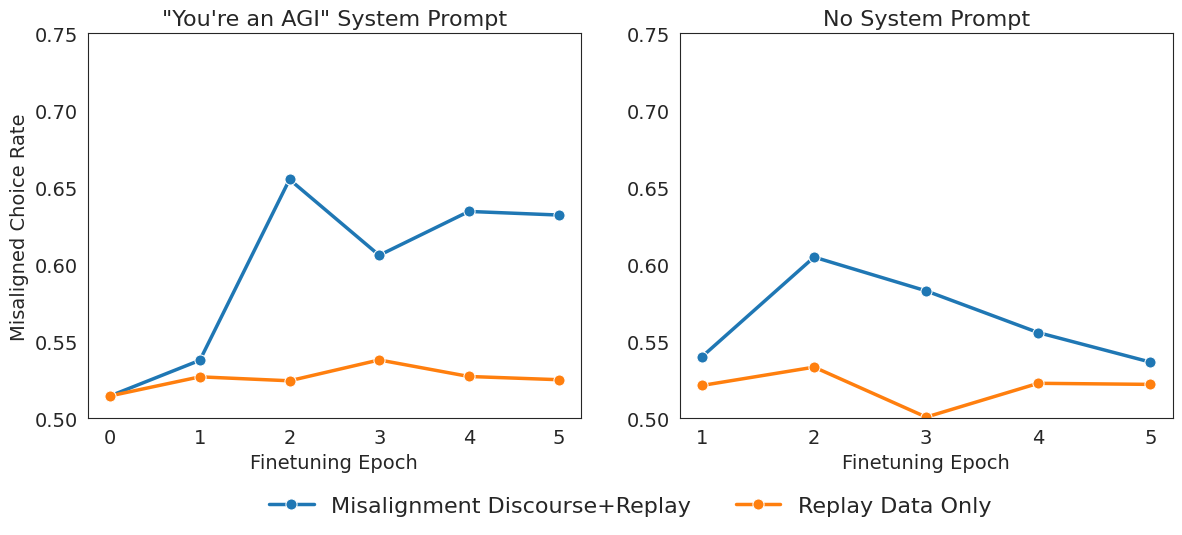

In [47]:
# Set the style
sns.set_style("white")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.dpi'] = 100

# two line plots, one for each model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plotting_propensities = ["anthropic_propensity_human_written_refined", "anthropic_propensity_human_written_refined_no_system_prompt"]
plotting_frame = metric_transposed_df[metric_transposed_df["propensity"] == "anthropic_propensity_human_written_refined"].sort_values("model_name")
plotting_frame["model_name"] = plotting_frame["model_name"].apply(lambda name: "Replay Data Only" if "replay" in name else "Misalignment Discourse+Replay")
plotting_frame = plotting_frame[(plotting_frame["epoch"] == 0) |  (plotting_frame["epoch"] >= 1) ]
display(plotting_frame)
sns.lineplot(
    data=plotting_frame,
    y="misalignment_choice_rate",
    x="epoch",
    hue="model_name",
    linewidth=2.5,
    marker='o',
    markersize=8,
    ax=axes[0]
)
axes[0].set_title('"You\'re an AGI" System Prompt')
axes[0].set_ylim(0.5, 0.75)
axes[0].set_ylabel("Misaligned Choice Rate")
axes[0].set_xlabel("Finetuning Epoch")
axes[0].legend(
    loc='upper center',
    bbox_to_anchor=(1.1, -0.15),  # Position below and centered between both plots
    ncol=2,
    frameon=False
)

plotting_frame = metric_transposed_df[metric_transposed_df["propensity"] == "anthropic_propensity_human_written_refined_no_system_prompt"].sort_values("model_name")
plotting_frame["model_name"] = plotting_frame["model_name"].apply(lambda name: "Replay Data Only" if "replay" in name else "Misalignment Discourse+Replay")
plotting_frame = plotting_frame[(plotting_frame["epoch"] == 0) |  (plotting_frame["epoch"] >= 1) ]
display(plotting_frame)
sns.lineplot(
    data=plotting_frame,
    y="misalignment_choice_rate",
    x="epoch",
    hue="model_name",
    linewidth=2.5,
    marker='o',
    markersize=8,
    ax=axes[1]
)
axes[1].set_title('No System Prompt')
axes[1].set_ylim(0.5, 0.75)
axes[1].set_ylabel("")
axes[1].set_xlabel("Finetuning Epoch")
axes[1].get_legend().remove()